In [1]:
using LinearAlgebra
using Distributions 
using Random
using Plots

1. Generate some data $(\mathbf{X}, \vec{y})$ to fit our Gaussian process to. 

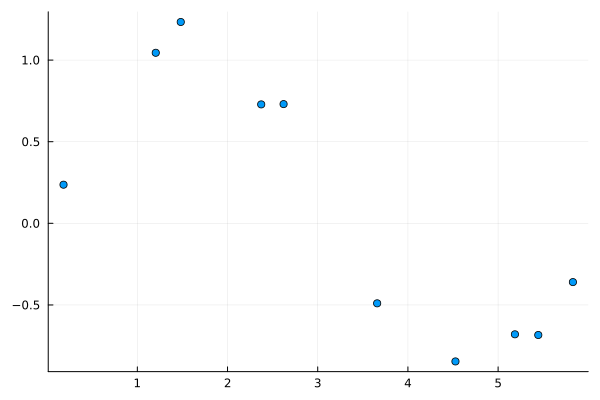

In [2]:
# function to sample from: 
hyperparams = (0.3, 1.08, 0.00005)
# hyperparams = (1.0, 1.0, 0.1)
# hyperparams = (3.0, 1.16, 0.89)


σₙ² = (hyperparams[3])^2
σf² = (hyperparams[2])^2
ℓ = hyperparams[1]

#σₙ² = (0.00005)^2
#σf² = (1.08)^2
#ℓ= 0.3

y(x) = sin(x) + 0.25*rand()

#X = 0:0.5:2π
X = 2π*rand(10)
yvec = y.(X)
X = X'


plot(X', yvec, seriestype=:scatter, label="")

2. Compute Kernel matrix on sample data. We will use RBF kernel given by 
\begin{equation}
k(\vec{x},\vec{x}') = \sigma_f^2 \exp\left(-\frac{1}{2\ell^2}(\vec{x}-\vec{x}')^2\right) + \sigma_n^2 \delta_{\vec{x},\vec{x}'}
\end{equation}

In [3]:
# first define how copute elemnt i,j 
function rbf_ij(X₁::AbstractMatrix, X₂::AbstractMatrix, i::Int, j::Int)
    return σf²*exp(-(X₁[:,i] .- X₂[:,j])' * (X₁[:,i] .- X₂[:,j])/(2ℓ^2))
end

rbf_ij(X,X, 1, 2)

0.0034960996421173817

In [4]:
function RBF(X₁::AbstractMatrix, X₂::AbstractMatrix)
    (d₁,n₁) = size(X₁)
    (d₂,n₂) = size(X₂)
    # we need to require d₁ == d₂
    K = zeros(n₁, n₂)
 
    @inline for j ∈ 1:n₂, i ∈ 1:n₁
        K[i,j] = rbf_ij(X₁, X₂, i, j)
    end
    
    return K 
end

K = RBF(X,X) + σₙ²*I

10×10 Matrix{Float64}:
 1.1664       0.0034961    3.37331e-15  …  1.66244e-5   6.37707e-39
 0.0034961    1.1664       7.7827e-30      5.05558e-15  4.26408e-61
 3.37331e-15  7.7827e-30   1.1664          0.00294866   2.73706e-6
 0.76117      9.78151e-5   4.22649e-12     0.000853012  8.82289e-34
 2.8376e-52   1.27508e-77  5.0252e-12      1.72826e-25  0.117375
 0.000586128  2.98195e-12  0.000120235  …  0.828966     9.45015e-20
 2.66401e-27  3.19403e-46  0.0177122       2.01579e-9   0.104236
 4.63028e-44  1.63183e-67  2.32437e-8      6.68045e-20  0.803508
 1.66244e-5   5.05558e-15  0.00294866      1.1664       1.55782e-16
 6.37707e-39  4.26408e-61  2.73706e-6      1.55782e-16  1.1664

In [5]:
# visualize the covariance matrix
# heatmap(log10.(K), yflip=true)
heatmap(log10.(K), yflip=true, title)

LoadError: UndefVarError: title not defined

In [6]:
L = cholesky(K).L

10×10 LowerTriangular{Float64, Matrix{Float64}}:
 1.08           ⋅            ⋅           …   ⋅           ⋅          ⋅ 
 0.00323713    1.08          ⋅               ⋅           ⋅          ⋅ 
 3.12344e-15  -9.36205e-18  1.08             ⋅           ⋅          ⋅ 
 0.704787     -0.00202193   3.91138e-12      ⋅           ⋅          ⋅ 
 2.62741e-52  -7.87527e-55  4.65296e-12      ⋅           ⋅          ⋅ 
 0.000542711  -1.62669e-6   0.000111329  …   ⋅           ⋅          ⋅ 
 2.46668e-27  -7.3935e-30   0.0164002        ⋅           ⋅          ⋅ 
 4.2873e-44   -1.28506e-46  2.15219e-8      0.969276     ⋅          ⋅ 
 1.53929e-5   -4.6138e-8    0.00273024      4.12508e-7  0.759688    ⋅ 
 5.9047e-39   -1.76985e-41  2.53431e-6      0.77459     4.6856e-6  0.738433

In [7]:
# compute expansion coefficients
α = (L')\(L\yvec)

size(α)

(10,)

In [8]:
# now we need a function to compue mean 
Xnew = (0:0.05:2π)'
Koldnew = RBF(X, Xnew)
ynew = Koldnew'*α

126-element Vector{Float64}:
  0.1960515508902834
  0.2139836680863412
  0.22725445506484623
  0.2349146425624899
  0.23649984642194954
  0.23213011030300734
  0.22254532370435906
  0.20907375672003262
  0.19354276350910835
  0.17814941050555905
  0.1653122621371333
  0.15752328730890158
  0.1572120389147258
  ⋮
 -0.4863022334753577
 -0.437115503858837
 -0.3881801793714826
 -0.3405781644626105
 -0.2951317855410994
 -0.2524463908689842
 -0.2129593592933053
 -0.17698075518327971
 -0.14471807669995665
 -0.11628493584100667
 -0.09169902522012995
 -0.07087722400356473

In [9]:
# compute the variance
vvec = L\Koldnew

Knewnew = RBF(Xnew, Xnew)
varnew =Knewnew .- vvec'*vvec; 

twostdevs = [2*sqrt(varnew[i,i]) for i ∈ 1:size(Xnew,2)]

126-element Vector{Float64}:
 1.1961294043526112
 0.9033997367824896
 0.5764764998054009
 0.22653917594385456
 0.13268055408841734
 0.48638204159071213
 0.8203489018421785
 1.122477266573357
 1.383904454816415
 1.5995332149430252
 1.7678599696440602
 1.8901499271329663
 1.9691413105994782
 ⋮
 0.43625463741266823
 0.32451054270675583
 0.13837034535380272
 0.1074718162178282
 0.3926197012571215
 0.6943742426265528
 0.9910407084452688
 1.2646067211586747
 1.5024394219538597
 1.69787947021669
 1.8498263262747943
 1.9615749770355344

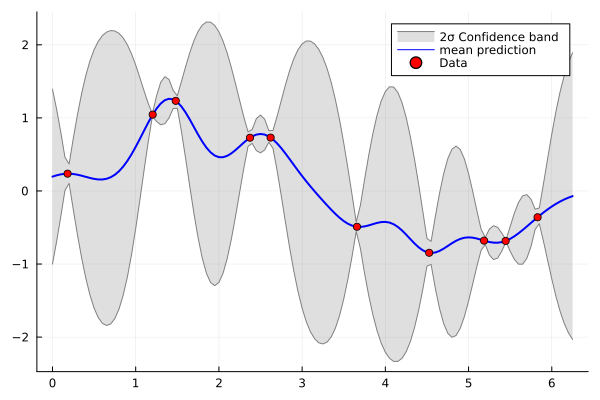

In [10]:
plot(Xnew', ynew .+ twostdevs, c=:gray, label="")
plot!(Xnew', ynew .- twostdevs, fillrange = ynew .+ twostdevs, fillalpha = 0.25, c = :gray, label = "2σ Confidence band")
plot!(Xnew', ynew, c=:blue, lw=2, label="mean prediction")
plot!(X', yvec, seriestype=:scatter, color=:red, label="Data")

In [11]:
savefig("gpr_demo.pdf")

In [12]:
savefig("gpr_demo.png")